In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy.random as rnd
from scipy.stats import chi
import lmfit
from lmfit import minimize, Parameters

# One atom

In [ ]:
width = 2
power = 50

def LG(x, w, P):
    return P*(4*x**2/(np.pi*w**4)*np.exp(-2*x**2/w**2))

def dLG(x, w, P):
    return P*(8*x/(np.pi*w**4)*np.exp(-2*x**2/w**2))*(1-2*x**2/w**2)

class SingleAtom(object):
    
    def __init__(self, r, x, vel):
        """Create an atom"""
        
        self.x_position = x
        self.y_position = LG(x, width, power)
        self.velocity = vel
        self.force = -dLG(x, width, power)
        self.radius = r
        
        
            
    def step(self, dt):
        self.x_position += dt * self.velocity
        self.y_position = LG(self.x_position, width, power)
        self.velocity += dt * self.force
        self.force = -dLG(self.x_position, width, power)
            

In [ ]:
x = 0.5
vel = 1.
atom = SingleAtom(0.05, x, vel)
X = np.linspace(-5,5,101)

fig = plt.figure()

ax = fig.add_subplot(111, aspect='equal')
line, = ax.plot([], [], 'bo', ms=10)
ax.set_xlim(-5,5)
plt.plot(X, LG(X, width, power))
    
def make_frame(i):
    atom.step(0.01)
    line.set_data(atom.x_position, atom.y_position)
    return line,
    
anim = animation.FuncAnimation(fig, make_frame, interval=10, blit=False)

# Several atoms

In [ ]:
width = 2

def LG(x, w, P):
    return P*(4*x**2/(np.pi*w**4)*np.exp(-2*x**2/w**2))

def dLG(x, w, P):
    return P*(8*x/(np.pi*w**4)*np.exp(-2*x**2/w**2))*(1-2*x**2/w**2)

class Atoms(object):
    
    def __init__(self, n_atoms, radius, p, freq, time):
        """Create an atom"""
        
        self.n_atoms = n_atoms
        self.radius = radius
        self.avg_power = p
        self.power = p
        self.freq = freq
        self.time = time
        self.x_positions = (rnd.random(n_atoms)-0.5)*0.3
        self.velocities = (rnd.random(n_atoms)-0.5)*1
        self.y_positions = LG(self.x_positions, width, self.power)
        self.forces = -dLG(self.x_positions, width, self.power)
        
            
    def step(self, dt):
        self.x_positions += dt * self.velocities
        self.y_positions = LG(self.x_positions, width, self.power)
        self.velocities += dt * self.forces
        self.forces = -dLG(self.x_positions, width, self.power)
        self.power += 0.3*self.avg_power*(2*np.pi*self.freq)*np.cos(2*np.pi*self.freq*self.time)*dt
        self.time += dt
            

In [ ]:
X = np.linspace(-5,5,101)
P_0 = 50
freq_modulation = 2

atoms = Atoms(100, 0.01, P_0, freq_modulation, 0)


fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
line, = ax.plot([], [], 'ro', ms=7)
trap, = plt.plot([], [])
ax.set_xlim(-5,5)
ax.set_ylim(0,4)
    
def animate(i):
    atoms.step(0.01)
    line.set_data(atoms.x_positions[:], atoms.y_positions[:])
    trap.set_data(X, LG(X, width, atoms.power))
    return line,
    
anim = animation.FuncAnimation(fig, animate, interval=5, blit=False)

In [ ]:
frac = np.zeros(200)
n_at = 200

for i in range(200):
    freq_modulation = i/100 +0.01

    atoms = Atoms(n_at, 0.01, P_0, freq_modulation, 0)

    for j in range(3000):
        atoms.step(0.01)
        
    for k in range(n_at):
        if atoms.x_positions[k]**2 > 4:
            frac[i] +=1
plt.figure()
plt.plot(np.arange(0,200), frac/n_at)
plt.ylim(0,1)

# Full simulation

In [2]:
width_LG = 45/np.sqrt(2)   #µm

k_B = 1.38*10**-23   #µm^2 Kg ms^-2 µK^-1

m_Rb = 85*1.6*10**-27    #kg

h = 6.62*10**-25   # µm^2 kg ms^-1

omega_l = 2*np.pi*(3*10**5)/(1064*10**-9)  #ms^-1

m_e = 9.1*10**-31   #kg

beta = (1/137)* h /(m_e * omega_l**2)   #proportionality factor b/w energy & intensity, µm^2 ms

def LG(x, w, P):      #J ms^-1 µm^-2
    return P*(4*(x**2)/(np.pi*w**4)*np.exp(-2*x**2/w**2))

def E(x, w, P):       #J
    return LG(x, w, P)*beta

def dLG(x, w, P):     #J ms^-1 µm^-3
    return P*(8*x/(np.pi*w**4)*np.exp(-2*x**2/w**2))*(1-2*x**2/w**2)

def dE(x, w, P):      # J µm^-1
    return dLG(x, w, P)*beta

class Atoms(object):
    
    def __init__(self, n_atoms, temp, w_g, x_0, p_0, freq, A, t):
        """Create an atom"""
        
        self.n_atoms = n_atoms
        
        self.temperature = temp
        
        self.velocities = np.random.normal(0, np.sqrt(k_B*temp/m_Rb), n_atoms)    #in µm ms^-1
        
        self.x_positions = np.random.normal(x_0, w_g/2, n_atoms)     #in µm
        
        self.avg_power = p_0
        
        self.power = p_0
        
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)   #kB in m^2 Kg s^-2 µK^-1
        
        self.freq = freq
        
        self.amp = A/100
        
        self.forces = -dE(self.x_positions, width_LG, self.power)    #J µm^-1
        
        self.time = t

            
    def step(self, dt):
        self.x_positions += dt * self.velocities
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)
        self.velocities += dt * (10**6)*self.forces/m_Rb     #10**6 to convert J=kg*m^2*s^-2 to kg*µm^2*ms^-2
        self.forces = -dE(self.x_positions, width_LG, self.power)
        self.power -= (self.amp/2)*self.avg_power*(2*np.pi*self.freq)*np.sin(2*np.pi*self.freq*self.time)*dt
        self.time += dt

<IPython.core.display.Javascript object>


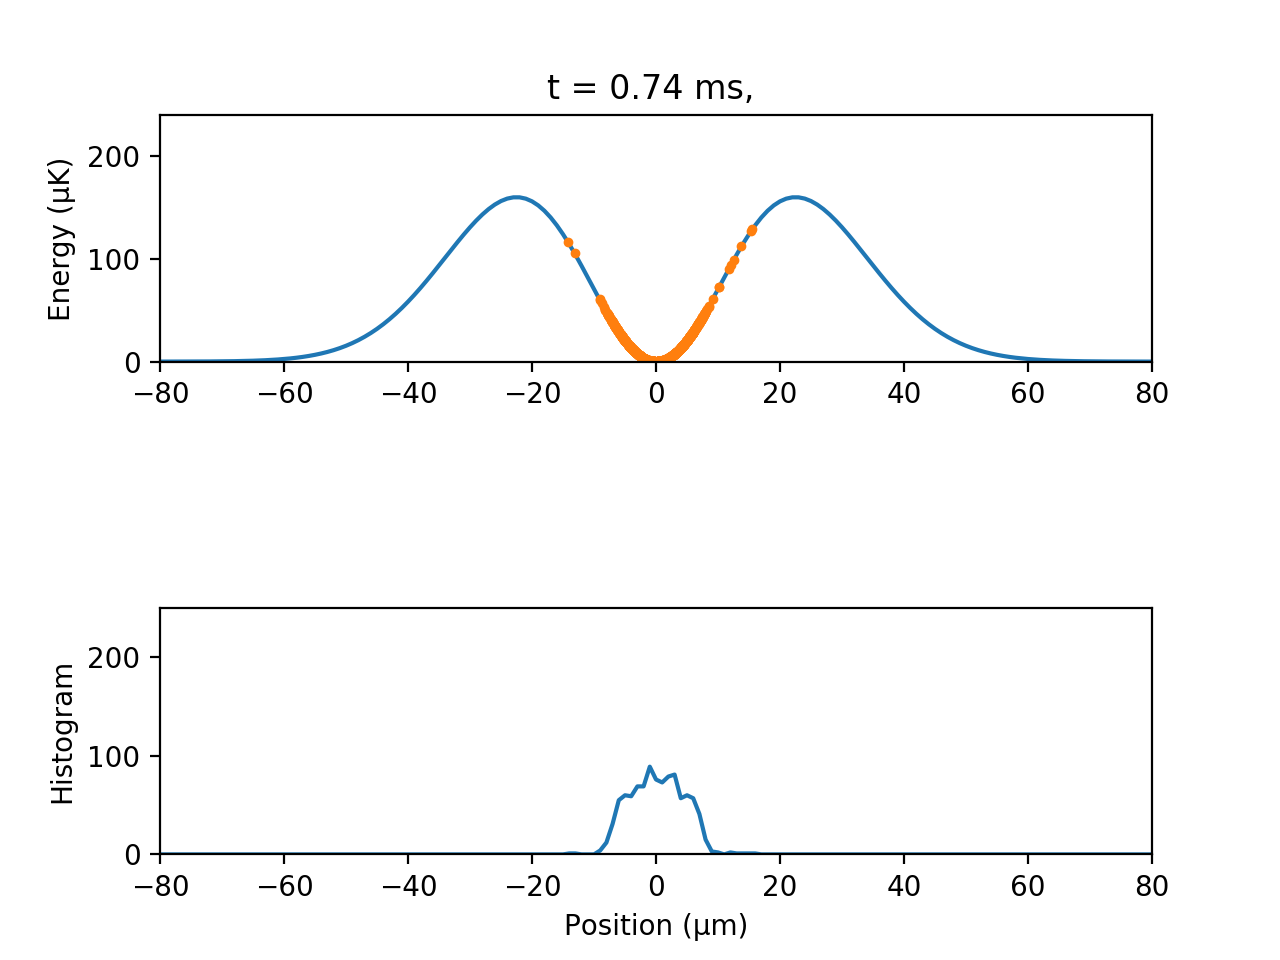

In [5]:
N_at = 1000

temperature =  5      #µK

width_blue = 10   #µm

init_offset = 0   #µm

P_0 = 5.65*10**-3    #J ms^-1

freq_modulation = 0.    #kHz

amp_modulation = 50   # in % of power

X = np.linspace(-80,80,161)
x = np.linspace(-80, 80, 161)

atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, freq_modulation, amp_modulation, 0)

def fit_gauss(pos, counts):  #fitting routine, exponential decay
    params = Parameters()
    params.add('x_0', value= 0, vary=True, min=-80., max=80.)
    params.add('A', value= 10000, vary=True)
    params.add('w', value = 10, vary = True, min = 0., max = 100.)

    result_fit = lmfit.minimize(fit_fc_gauss, params, args=(pos, counts))
    width = result_fit.params['w'].value
    center = result_fit.params['x_0'].value
    amp = result_fit.params['A'].value
    return width, center, amp

def fit_fc_gauss(params, x, data):   #fitting function, exponential decay
    x_0 = params['x_0'].value
    A = params['A'].value
    sigma = params['w'].value
    model = A/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-x_0)**2/(2*sigma**2))
    return (data - model)

fig = plt.figure()
fig.subplots_adjust(hspace = 1)
fig.subplots_adjust(wspace = 0.5)
ax = fig.add_subplot(211)
trap, = ax.plot([], [])
line, = ax.plot([], [], '.', ms=5)
ax.set_xlim(-80, 80)
ax.set_ylim(0, 1.5*np.max(E(X, width_LG, atoms.power)/(k_B*10**-6)))
#plt.xlabel('Position (µm)')
plt.ylabel('Energy (µK)')

ax2 = fig.add_subplot(212)
hist, = ax2.plot([], [])
fit, = ax2.plot([], [])
plt.xlabel('Position (µm)')
plt.ylabel('Histogram')
ax2.set_ylim(0, 250)
ax2.set_xlim(-80, 80)

#ax3 = fig.add_subplot(413)
#centers = []
#center, = ax3.plot([],[])
#plt.ylabel('Center of cloud')
#ax3.set_xlim(0, 10)
#ax3.set_ylim(-15, 15)

#ax4 = fig.add_subplot(414)
#waists = []
#waist, = ax4.plot([],[])
#plt.ylabel('Waist of cloud')
#ax4.set_xlim(0, 10)
#ax4.set_ylim(0, 20)


def animate(i):
    
    atoms.step(0.001)   #time step, in ms; 1 µs steps

    trap.set_data(X, E(X, width_LG, atoms.power)/(k_B*10**-6))
    line.set_data(atoms.x_positions, atoms.y_positions)
    
    histogram = np.histogram(atoms.x_positions, 161, range=(-80,80))[0]
    hist.set_data(x, histogram)
    
    #f = fit_gauss(x, histogram)
    #fit.set_data(x, f[2]/(f[0]*np.sqrt(2*np.pi)) * np.exp(-(x-f[1])**2/(2*f[0]**2)))
    
    ax.set_title('t = ' + str(np.round(atoms.time, 2)) + ' ms, ')
    
    #centers.append(np.mean([x for x in atoms.x_positions if x**2 < 30**2]))
    #center.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , centers)
    
    #waists.append(np.std([x for x in atoms.x_positions if x**2 < 30**2]))
    #waist.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , waists)
    
    return line, trap, #center, waist

anim = animation.FuncAnimation(fig, animate, interval=2, blit=False)

In [ ]:
frac = np.zeros(100)
frequencies = np.zeros(100)
for i in range(100):
    frequencies[i] = 0.01+i*0.06
    
total_time = 5.5

N_at = 500

temperature =  5  #µK

width_blue = 3    #µm

init_offset = 0   #µm

P_0 = 6*10**-3    #J ms^-1

amp_modulation = 50   # in % of power

for i in range(100):
    freq_modulation = frequencies[i]

    atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, frequencies[i], amp_modulation, 0)

    for j in range(int(total_time/0.0005)):
        atoms.step(0.0005)
        
    for k in range(N_at):
        if(atoms.x_positions[k]**2 > 40**2):
            frac[i] +=1
plt.figure()
plt.plot(frequencies, frac/N_at)
plt.ylim(0,1)
plt.xlabel('Modulation Frequency (kHz)')
plt.ylabel('Fraction of ejected atoms')
plt.title('Parametric excitation, 1D LG, ' + str(amp_modulation) + '% modulation')
plt.savefig('1DsimLG.png', format = 'png', dpi = 1000)

# Harmonic trap

In [6]:
width_LG = 45/np.sqrt(2)   #µm

k_B = 1.38*10**-23   #µm^2 Kg ms^-2 µK^-1

m_Rb = 85*1.6*10**-27    #kg

h = 6.62*10**-25   # µm^2 kg ms^-1

omega_l = 2*np.pi*(3*10**5)/(1064*10**-9)  #ms^-1

m_e = 9.1*10**-31   #kg

beta = (1/137)* h /(m_e * omega_l**2)   #proportionality factor b/w energy & intensity, µm^2 ms

def LG(x, w, P):      #J ms^-1 µm^-2
    return np.heaviside(np.sqrt((20/x)**2)-1, 0.5)*P*4*(x**2)/(np.pi*w**4)

def E(x, w, P):       #J
    return LG(x, w, P)*beta

def dLG(x, w, P):     #J ms^-1 µm^-3
    return np.heaviside(np.sqrt((20/x)**2)-1, 0.5)*P*8*x/(np.pi*w**4)

def dE(x, w, P):      # J µm^-1
    return dLG(x, w, P)*beta

class Atoms(object):
    
    def __init__(self, n_atoms, temp, w_g, x_0, p_0, freq, A, t):
        """Create an atom"""
        
        self.n_atoms = n_atoms
        
        self.temperature = temp
        
        self.velocities = np.random.normal(0, np.sqrt(k_B*temp/m_Rb), n_atoms) 
        
        self.x_positions = np.random.normal(x_0, w_g/2, n_atoms)     #in µm
        
        self.avg_power = p_0
        
        self.power = p_0
        
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)   #kB in m^2 Kg s^-2 µK^-1
        
        self.freq = freq
        
        self.amp = A/100
        
        self.forces = -dE(self.x_positions, width_LG, self.power)    #J µm^-1
        
        self.time = t

            
    def step(self, dt):
        self.x_positions += dt * self.velocities
        self.y_positions = E(self.x_positions, width_LG, self.power)/(k_B*10**-6)
        self.velocities += dt * (10**6)*self.forces/m_Rb     #10**6 to convert J=kg*m^2*s^-2 to kg*µm^2*ms^-2
        self.forces = -dE(self.x_positions, width_LG, self.power)
        self.power += self.amp*self.avg_power*(2*np.pi*self.freq)*np.cos(2*np.pi*self.freq*self.time)*dt
        self.time += dt

In [ ]:
N_at = 1000

temperature =  5      #µK

width_blue = 3    #µm

init_offset = 10   #µm

P_0 = 6.48*10**-3    #J ms^-1

freq_modulation = 0.     #kHz

amp_modulation = 75   # in % of power

X = np.linspace(-80,80,161)
x = np.linspace(-80, 80, 161)

atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, freq_modulation, amp_modulation, 0)

def fit_gauss(pos, counts):  #fitting routine, exponential decay
    params = Parameters()
    params.add('x_0', value= 0, vary=True, min=-80., max=80.)
    params.add('A', value= 10000, vary=True)
    params.add('w', value = 10, vary = True, min = 0., max = 100.)

    result_fit = lmfit.minimize(fit_fc_gauss, params, args=(pos, counts))
    width = result_fit.params['w'].value
    center = result_fit.params['x_0'].value
    amp = result_fit.params['A'].value
    return width, center, amp

def fit_fc_gauss(params, x, data):   #fitting function, exponential decay
    x_0 = params['x_0'].value
    A = params['A'].value
    sigma = params['w'].value
    model = A/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-x_0)**2/(2*sigma**2))
    return (data - model)

fig = plt.figure()
fig.subplots_adjust(hspace = 1)
fig.subplots_adjust(wspace = 0.5)
ax = fig.add_subplot(411)
trap, = ax.plot([], [])
line, = ax.plot([], [], 'ro', ms=5)
ax.set_xlim(-80, 80)
ax.set_ylim(0, 1.5*np.max(E(X, width_LG, atoms.power)/(k_B*10**-6)))
#plt.xlabel('Position (µm)')
plt.ylabel('Energy (µK)')

ax2 = fig.add_subplot(412)
hist, = ax2.plot([], [])
fit, = ax2.plot([], [])
plt.xlabel('Position (µm)')
plt.ylabel('Histogram')
ax2.set_ylim(0, 300)
ax2.set_xlim(-80, 80)

ax3 = fig.add_subplot(413)
centers = []
center, = ax3.plot([],[])
plt.ylabel('Center of cloud')
ax3.set_xlim(0, 10)
ax3.set_ylim(-15, 15)

ax4 = fig.add_subplot(414)
waists = []
waist, = ax4.plot([],[])
plt.ylabel('Waist of cloud')
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 20)


def animate(i):
    
    atoms.step(0.001)   #time step, in ms; 1 µs steps

    trap.set_data(X, E(X, width_LG, atoms.power)/(k_B*10**-6))
    line.set_data(atoms.x_positions, atoms.y_positions)
    
    histogram = np.histogram(atoms.x_positions, 161, range=(-80,80))[0]
    hist.set_data(x, histogram)
    
    #f = fit_gauss(x, histogram)
    #fit.set_data(x, f[2]/(f[0]*np.sqrt(2*np.pi)) * np.exp(-(x-f[1])**2/(2*f[0]**2)))
    
    ax.set_title('t = ' + str(np.round(atoms.time, 2)) + ' ms, ')
    
    centers.append(np.mean(atoms.x_positions))
    center.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , centers)
    
    waists.append(np.std(atoms.x_positions))
    waist.set_data(np.linspace(0.,np.shape(centers)[0]*0.001, np.shape(centers)[0]) , waists)
    
    return line, trap, center, waist

anim = animation.FuncAnimation(fig, animate, interval=1, blit=False)

In [ ]:
frac = np.zeros(100)
frequencies = np.zeros(100)
for i in range(100):
    frequencies[i] = 0.01+i*0.06
    
total_time = 5.5

N_at = 500

temperature =  5  #µK

width_blue = 3    #µm

init_offset = 0   #µm

P_0 = 6*10**-3    #J ms^-1

amp_modulation = 50   # in % of power

for i in range(100):
    freq_modulation = frequencies[i]

    atoms = Atoms(N_at,  temperature, width_blue, init_offset, P_0, frequencies[i], amp_modulation, 0)

    for j in range(int(total_time/0.0005)):
        atoms.step(0.0005)
        
    for k in range(N_at):
        if(atoms.x_positions[k]**2 > 40**2):
            frac[i] +=1
plt.figure()
plt.plot(frequencies, frac/N_at)
plt.ylim(0,1)
plt.xlabel('Modulation Frequency (kHz)')
plt.ylabel('Fraction of ejected atoms')
plt.title('Parametric excitation, 1D Gauss, ' + str(amp_modulation) + '% modulation')
plt.savefig('1DsimG.png', format = 'png', dpi = 1000)